<a href="https://colab.research.google.com/github/Stephane-Masamba/Team_4_CPT_ML-Classification/blob/Mikael/Copy_of_Mikael_Daniels_Classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                       *Climate* *Change* *Belief* *Analysis*



---











#Introduction

Many companies are built around lessening their environmental impact and thus they offer products that are environmentally friendly and sustainable. With that, they would like to determine how people perceive climate change.






This notebook aims to build Machine Learning Classification model(s) that is able to classify accurately whether or not a person believes in climate change based on their novel tweet.

This will be done by importing necesarry libraries as well as the training and test datasets. Data cleaning follows together with exploratory data analysis.We then wrap up the notebook by diving into different classification techniques under the Modelling section which will be followed by insights and a conclusion.

The following are some of the few Classification techniques explored in this notebook:

1.Support Vector Machines

2.Bernoulli

3.Multinomial

4.Random Forest

5.


#Imports

###Import Libraries

In [3]:
!pip install spacy
!pip install NLTK

In [4]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from numpy import arange

import re
import spacy.cli
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import  KFold

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import resample

#Machine Learning Models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from google.colab import drive

In [5]:
spacy.cli.download('en_core_web_sm')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nlp = spacy.load('en_core_web_sm')

#Read in the datasets

In [7]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [8]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


#Data description

The data available aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. Each tweet is labelled as one of four classes.



###Classes and description

Class 2 : News-the tweet links to factual news about climate change

Class 1 : Pro-the tweet supports the belief of man-made climate change

Class 0 : Neutral-the tweet neither supports nor refutes the belief of man-made climate change

Class -1 : Anti-the tweet does not believe in man-made climate change

###Variables definitions

sentiment: Sentiment of tweet

message: Tweet body

tweetid: Twitter unique id

#Data Cleaning

Knowing that we are dealing with text data, we decided to first clean the data by making all tweets lower-case, removing punctuation marks and removing white spaces before doing anything else. Also, replacing all links with the word 'LINK' and all user handles with 'USER_REF'

In [103]:
def clean_text(df):
    i = 0
    for tweet in df['message']:
      tweet = tweet.lower()
      tweet = re.sub(r'http\S+', 'LINK', tweet)
      tweet = re.sub(r'@\S+', 'USER_REF', tweet)
      tweet = re.sub(r'[^\w\s]', '', tweet)
      tweet = tweet.lstrip()
      tweet = tweet.rstrip()
      tweet = tweet.replace('  ', ' ')
      df.loc[i, 'message'] = tweet
      i += 1

      return df

In [10]:
clean_text(train)
train

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt USER_REF researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736
4,1,rt USER_REF its 2016 and a racist sexist clima...,466954
...,...,...,...
15814,1,rt USER_REF they took down the material on glo...,22001
15815,2,rt USER_REF how climate change could be breaki...,17856
15816,0,notiven rt nytimesworld what does trump actual...,384248
15817,-1,rt USER_REF hey liberals the climate change cr...,819732


In [11]:
clean_text(test)

Here we add 'LINK' and 'USER_REF' to our list of stop words and remove all stop words from each tweet

In [12]:
def remove_stopwords(df):
    my_stop_words = stopwords.words('english')
    my_stop_words.append('LINK')
    my_stop_words.append('USER_REF')

    df_index = 0

    for tweet in df['message']:
      tweet = word_tokenize(tweet)
      tweet = [word for word in tweet if not word in my_stop_words]
      tweet = ' '.join(tweet)

      df.loc[df_index, 'message'] = tweet
      df_index += 1

    return df

In [13]:
remove_stopwords(train)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [15]:
remove_stopwords(test)

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,combine polling staffers climate change womens...,35326
2,scary unimpeachable evidence climate change al...,224985
3,putin got jill trump doesnt believe climate ch...,476263
4,rt female orgasms cause global warming sarcast...,872928
...,...,...
10541,rt brb writing poem climate change climatechan...,895714
10542,2016 year climate change came home hottest yea...,875167
10543,rt pacific countries positive fiji leading glo...,78329
10544,rt youre hot must cause global warming aldubla...,867455


###Find all named entities for each tweet

In [17]:
def entities(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)

      for entity in tweet.ents:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(entity.text), str(entity.label_))

      df_index += 1

      return df

In [18]:
entities(train)

,sentiment,message,tweetid
0,1,ORG chief doesnt think carbon dioxide main cau...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [19]:
entities(test)

,message,tweetid
0,LOC looking GPE make sure alone fighting clima...,169760
1,combine polling staffers climate change womens...,35326
2,scary unimpeachable evidence climate change al...,224985
3,putin got jill trump doesnt believe climate ch...,476263
4,rt female orgasms cause global warming sarcast...,872928
...,...,...
10541,rt brb writing poem climate change climatechan...,895714
10542,2016 year climate change came home hottest yea...,875167
10543,rt pacific countries positive fiji leading glo...,78329
10544,rt youre hot must cause global warming aldubla...,867455


###Lemmatize every word in each tweet

In [20]:
def lem_text(df):
    df_index = 0

    for tweet in df['message']:
      tweet = nlp(tweet)
      
      for token in tweet:
        df.loc[df_index, 'message'] = df.loc[df_index, 'message'].replace(str(token.text), str(token.lemma_))

      df_index += 1

      return df

In [21]:
lem_text(train)

,sentiment,message,tweetid
0,1,ORG chief donot think carbon dioxide main caus...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [23]:
lem_text(test)

,message,tweetid
0,LOC look gpe make sure alone fight climate change,169760
1,combine polling staffers climate change womens...,35326
2,scary unimpeachable evidence climate change al...,224985
3,putin got jill trump doesnt believe climate ch...,476263
4,rt female orgasms cause global warming sarcast...,872928
...,...,...
10541,rt brb writing poem climate change climatechan...,895714
10542,2016 year climate change came home hottest yea...,875167
10543,rt pacific countries positive fiji leading glo...,78329
10544,rt youre hot must cause global warming aldubla...,867455


#Exploratory Data Analysis

Now it is time to analyse the data and how it is structured.

###Missing values

In [24]:
train.isnull().sum()


sentiment    0
message      0
tweetid      0
dtype: int64

In [25]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

There are no missing values in both the train and test datasets

###Sentiment Classes

In [26]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

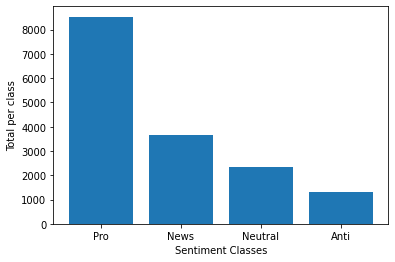

In [27]:
counts = train["sentiment"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])

plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

In [29]:
#Percentage of the major class
len(train[train.sentiment==1])/len(train.sentiment)

0.5392249826158417

The 'Pro' climate change class accounts for 54% of the data set and the remaining 46% is shared amongst the three other classes. This imbalance indicates how biased our model might me thus exploring resampling techniques might be required in order to improve the model accuracy.

###Any other data analysis/visual please

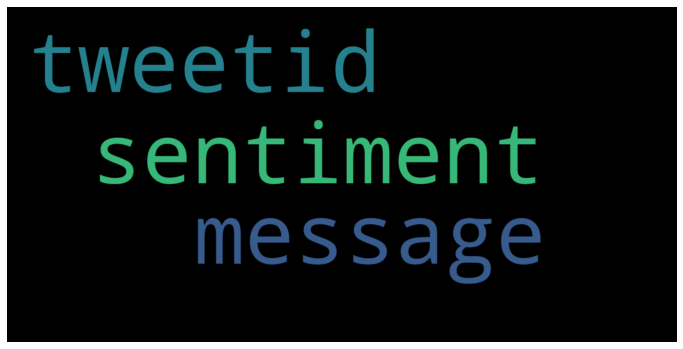

In [30]:
#Replace this code with one that gives words in tweets

neg_tweets = train[train.sentiment == -1]
neg_string = []
for t in neg_tweets:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#Define our feature and target variable to use when modelling

In [38]:
X = train['message']
X

0        ORG chief donot think carbon dioxide main caus...
1          like lack evidence anthropogenic global warming
2        rt researchers say three years act climate cha...
3        todayinmaker wired 2016 pivotal year war clima...
4        rt 2016 racist sexist climate change denying b...
                               ...                        
15814    rt took material global warming lgbt rights he...
15815    rt climate change could breaking 200millionyea...
15816    notiven rt nytimesworld trump actually believe...
15817    rt hey liberals climate change crap hoax ties ...
15818             rt climate change equation 4 screenshots
Name: message, Length: 15819, dtype: object

In [32]:
y = train['sentiment']
y

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert features to machine language

In [130]:
#tf_vect = TfidfVectorizer(ngram_range=(1, 2))
#X = tf_vect.fit_transform(X)

In [131]:
#X.shape

(15819, 93956)

In [39]:
tf_vecto = TfidfVectorizer(lowercase = True,stop_words = 'english',ngram_range=(1, 2))
X = tf_vecto.fit_transform(X)

In [40]:
X.shape

(15819, 88009)

###Splitting the data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
#X_test = test['message']

In [35]:
#X_test = tf_vect.transform(X_test)

#Modelling

##Modelling with maximum data cleaning

The function below takes in a model and returns the average accuracy score

In [42]:
def accuracy(model):
    features = train['message']
    target = train['sentiment']

    train_scores = []
    test_scores = []

    #tf_vect = TfidfVectorizer(ngram_range=(1, 2))
    tf_vecto = TfidfVectorizer(lowercase = True,stop_words = 'english',ngram_range=(1, 2))


    folds = KFold(n_splits=5, shuffle=True)

    for train_index, test_index in folds.split(features):
        x_train, x_test = features.iloc[train_index], features.iloc[test_index]    
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        x_train = tf_vecto.fit_transform(x_train)
        x_test = tf_vecto.transform(x_test)
     
        model.fit(x_train, y_train)
        train_predictions = model.predict(x_train)
        test_predictions = model.predict(x_test)

        train_score = accuracy_score(y_train, train_predictions)
        train_scores.append(train_score)

        test_score = accuracy_score(y_test, test_predictions)
        test_scores.append(test_score)

    avg_train_accuracy = np.mean(train_scores)
    avg_test_accuracy = np.mean(test_scores)

    return [avg_train_accuracy, avg_test_accuracy]


###Support Vector Machines(SVM)

Support-Vector Machines algorithm goes like blah blah blah blah

In [43]:
sv = SVC()

sv_accuracy = accuracy(sv)
sv_accuracy

[0.9736867245648273, 0.7050377248311606]

###Bernoulli

In [44]:
bernoulli = BernoulliNB()

bernoulli_accuracy = accuracy(bernoulli)
bernoulli_accuracy

[0.7299608433178274, 0.6202040182530867]

###Multi Nomial

In [45]:
mnb = MultinomialNB()

mnb_accuracy = accuracy(mnb)
mnb_accuracy

[0.723939524110886, 0.6389151907744932]

###SGD

In [46]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy

[0.9516878519256291, 0.7271641366895116]

###Random Forest

In [47]:
rand_forest = RandomForestClassifier()

rand_forest_accuracy = accuracy(rand_forest)
rand_forest_accuracy

[0.9972343384509953, 0.6774762753439042]

###K-Nearest Neighbors (KNN)

In [48]:
knn = KNeighborsClassifier()

knn_accuracy = accuracy(knn)
knn_accuracy

[0.7353498789473237, 0.6263984687039981]

###GradientBoostingClassifier

In [49]:
grad_booster = GradientBoostingClassifier()

grad_booster_accuracy = accuracy(grad_booster)
grad_booster_accuracy

[0.6824546645614606, 0.6409382665323171]

###Extra Trees Classifier

In [50]:
extra_trees = ExtraTreesClassifier()

extra_trees_accuracy = accuracy(extra_trees)
extra_trees_accuracy

[0.9972343421972096, 0.7024461086687773]

###Bagging

In [51]:
bagging = BaggingClassifier()

bagging_accuracy = accuracy(bagging)
bagging_accuracy

[0.9688191270221441, 0.6149570552049155]

###Decision Tree Classifier

In [52]:
dec_tree = DecisionTreeClassifier()

dec_tree_accuracy = accuracy(dec_tree)
dec_tree_accuracy

[0.9972501437297611, 0.5873949861966727]

###Linear SVC

In [53]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy

[0.9940103587824503, 0.7296918422675589]

##Plot all models and respective accuracy scores

Below is a graph of all models which allows for simplified comparison


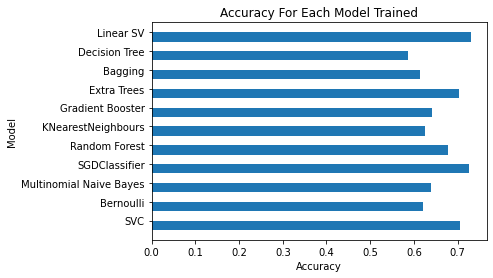

In [54]:
models = ['SVC', 'Bernoulli', 'Multinomial Naive Bayes', 'SGDClassifier', 'Random Forest', 'KNearestNeighbours', 'Gradient Booster', 'Extra Trees', 'Bagging', 'Decision Tree', 'Linear SV']
bar_widths = [sv_accuracy[1], bernoulli_accuracy[1], mnb_accuracy[1], sgd_accuracy[1], rand_forest_accuracy[1], knn_accuracy[1], grad_booster_accuracy[1], extra_trees_accuracy[1], bagging_accuracy[1], dec_tree_accuracy[1], linear_sv_accuracy[1]]
bar_positions = arange(11) + 0.75
tick_positions = range(1,12)

fig, ax = plt.subplots()
ax.barh(bar_positions, bar_widths, 0.5)
ax.set_yticks(tick_positions)
ax.set_yticklabels(models)

ax.set_ylabel('Model')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy For Each Model Trained')

plt.show()

###Fit best models and use the metrics module

In [55]:
linear_sv.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [56]:
#confusion matrix and classification_report
y_pred = linear_sv.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_pred))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_pred)))
print("\n\nClassification Report:\n\n", classification_report(y_test,y_pred,target_names=['Anti', 'Neutral','Pro','News']))

[[  99   30  142    7]
 [  10  147  250   18]
 [   9   46 1585  115]
 [   3   10  199  494]]


Accuracy score: 0.7348293299620733


Classification Report:

               precision    recall  f1-score   support

        Anti       0.82      0.36      0.50       278
     Neutral       0.63      0.35      0.45       425
         Pro       0.73      0.90      0.81      1755
        News       0.78      0.70      0.74       706

    accuracy                           0.73      3164
   macro avg       0.74      0.58      0.62      3164
weighted avg       0.73      0.73      0.72      3164



In [57]:
sgd.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [58]:
y_predict = sgd.predict(X_test)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,y_predict))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_pred)))
print("\n\nClassification Report:\n\n", classification_report(y_test,y_predict,target_names=['Anti', 'Neutral','Pro','News']))



[[  90   25  154    9]
 [   6  124  278   17]
 [   3   33 1606  113]
 [   4    6  218  478]]


Accuracy score: 0.7348293299620733


Classification Report:

               precision    recall  f1-score   support

        Anti       0.87      0.32      0.47       278
     Neutral       0.66      0.29      0.40       425
         Pro       0.71      0.92      0.80      1755
        News       0.77      0.68      0.72       706

    accuracy                           0.73      3164
   macro avg       0.75      0.55      0.60      3164
weighted avg       0.73      0.73      0.70      3164



##Modelling with resampled data


Since there has already been an observation that the data is imbalanced, one must attempt improving the accuracy of the above modelling. 


This will be done by introducing resampling techniques, Downsampling and SMOTE.

###Downsampling

In [59]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [60]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())

                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


Clean the data by calling the cleaning functions

In [61]:
clean_text(train)
remove_stopwords(train)
entities(train)
lem_text(train)

,sentiment,message,tweetid
0,1,ORG chief donot think carbon dioxide main caus...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [75]:
train_majority = train[train.sentiment== 1]
train_0 = train[train.sentiment== 0]
train_2 = train[train.sentiment== 2]

train_minority = train[train.sentiment==-1]



In [76]:
# Downsample majority classes
train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1296,     # to match minority class
                                 random_state=123) # reproducible results


train_0_downsampled = resample(train_0, 
                                 replace=False,    
                                 n_samples=1296,     
                                 random_state=123) 

train_2_downsampled = resample(train_2, 
                                 replace=False,    
                                 n_samples=1296,     
                                 random_state=123) 

                      



# Combine minority class with downsampled majority class
train_downsampled1 = pd.concat([train_0_downsampled,train_2_downsampled])

train_downsampled2 = pd.concat([train_majority_downsampled, train_minority])

train_downsampled =  pd.concat([train_downsampled1, train_downsampled2])

In [77]:
train_downsampled

,sentiment,message,tweetid
13470,0,rt really god global warming exist movie pulp ...,574574
8148,0,also storm global warming maybe probably,761606
11544,0,rt savor ur cold ones u climate change gon na ...,639609
7282,0,rt ive begun miss days endless papers global w...,121132
12634,0,omg celebrities moral actions climate change s...,744560
...,...,...,...
15704,-1,rt point wthe delusional left literally every ...,890582
15705,-1,rt al gore admits paris accord wont solve issu...,380307
15711,-1,rt funny people believe climate change bc scie...,390339
15806,-1,rt al gore idiot thinks climate change cause p...,213863


In [78]:
train_downsampled['sentiment'].value_counts()

-1    1296
 2    1296
 1    1296
 0    1296
Name: sentiment, dtype: int64

Now that the data is balanced, we go ahead and build a model. This time we check the performance with onlyy the two best performing models as per the above graph.

In [79]:
X_down = train['message']
X_down

0        ORG chief donot think carbon dioxide main caus...
1          like lack evidence anthropogenic global warming
2        rt researchers say three years act climate cha...
3        todayinmaker wired 2016 pivotal year war clima...
4        rt 2016 racist sexist climate change denying b...
                               ...                        
15814    rt took material global warming lgbt rights he...
15815    rt climate change could breaking 200millionyea...
15816    notiven rt nytimesworld trump actually believe...
15817    rt hey liberals climate change crap hoax ties ...
15818             rt climate change equation 4 screenshots
Name: message, Length: 15819, dtype: object

In [80]:
y_down = train['sentiment']
y_down

0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

In [81]:
X_down = tf_vecto.fit_transform(X_down)
X_down

<15819x88009 sparse matrix of type '<class 'numpy.float64'>'
	with 300338 stored elements in Compressed Sparse Row format>

In [82]:
#train_test_split
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_down,y_down,test_size=0.2,random_state=0)

In [83]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC()
lsvm.fit(X_train1, y_train1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [87]:
#confusion matrix and classification_report
y_pred1 = lsvm.predict(X_test1)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print(confusion_matrix(y_test1,y_pred1))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test1, y_pred1)))
print("\n\nClassification Report:\n\n",classification_report(y_test1,y_pred1,target_names=['Anti', 'Neutral','Pro','News']))

[[  77   23  129   20]
 [  12  149  278   34]
 [  12   50 1530  109]
 [   4    8  199  530]]


Accuracy score: 0.7225031605562579


Classification Report:

               precision    recall  f1-score   support

        Anti       0.73      0.31      0.44       249
     Neutral       0.65      0.32      0.42       473
         Pro       0.72      0.90      0.80      1701
        News       0.76      0.72      0.74       741

    accuracy                           0.72      3164
   macro avg       0.72      0.56      0.60      3164
weighted avg       0.72      0.72      0.70      3164



###SMOTE 

In [88]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Using data from the first data split

In [89]:
print(X_train.shape,y_train.shape)

(12655, 88009) (12655,)


In [97]:
smote = SMOTE("minority")
X_sm , y_sm = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [98]:
print(X_sm.shape,y_sm.shape)

(18412, 88009) (18412,)


In [112]:
ls= LinearSVC()
ls.fit(X_sm, y_sm)


#confusion matrix and classification_report
y_predsm = ls.predict(X_test)

print(confusion_matrix(y_test,y_predsm))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test, y_predsm)))
print("\n\nClassification Report:\n\n",classification_report(y_test,y_predsm,target_names=['Anti', 'Neutral','Pro','News']))

[[ 133   19  119    7]
 [  38  120  250   17]
 [  34   46 1562  113]
 [   8   12  196  490]]


Accuracy score: 0.7285082174462706


Classification Report:

               precision    recall  f1-score   support

        Anti       0.62      0.48      0.54       278
     Neutral       0.61      0.28      0.39       425
         Pro       0.73      0.89      0.80      1755
        News       0.78      0.69      0.74       706

    accuracy                           0.73      3164
   macro avg       0.69      0.59      0.62      3164
weighted avg       0.72      0.73      0.71      3164



##Modelling with minimal data cleaning

To conclude the modelling section, we will explore what one could have done by intuition. This is just to check how accurate our model would be if we did not introduce the 'fancy' cleaning functions.

In [77]:
train = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/train%20(1).csv')
print(train.head())

   sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954


In [100]:
test = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/test%20(1).csv')
print(test.head())


                                             message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928


In [101]:
sample = pd.read_csv('https://raw.githubusercontent.com/Stephane-Masamba/Team_4_CPT_ML-Classification/Mikael/sample_submission.csv')
print(sample.head())


   tweetid  sentiment
0   169760          1
1    35326          1
2   224985          1
3   476263          1
4   872928          1


This time we only call one cleaning function which is the clean_text() function. This does not include tokenization as well as lemmatization

In [106]:
clean_text(train)
remove_stopwords(train)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt researchers say three years act climate cha...,698562
3,1,todayinmaker wired 2016 pivotal year war clima...,573736
4,1,rt 2016 racist sexist climate change denying b...,466954
...,...,...,...
15814,1,rt took material global warming lgbt rights he...,22001
15815,2,rt climate change could breaking 200millionyea...,17856
15816,0,notiven rt nytimesworld trump actually believe...,384248
15817,-1,rt hey liberals climate change crap hoax ties ...,819732


In [107]:
clean_text(test)
remove_stopwords(test)

,message,tweetid
0,europe looking china make sure alone fighting ...,169760
1,Combine polling staffers climate change womens...,35326
2,"The scary , unimpeachable evidence climate cha...",224985
3,@ Karoli @ morgfair @ OsborneInk @ dailykos Pu...,476263
4,RT @ FakeWillMoore : 'Female orgasms cause glo...,872928
...,...,...
10541,"RT @ BrittanyBohrer : Brb , writing poem clima...",895714
10542,2016 : year climate change came home : During ...,875167
10543,RT @ loop_vanuatu : Pacific countries positive...,78329
10544,"RT @ xanria_00018 : You ’ hot , must cause glo...",867455


###Features and Modelling

In [108]:
X_min = train['message']
X_min


0        polyscimajor epa chief doesnt think carbon dio...
1          like lack evidence anthropogenic global warming
2        rt researchers say three years act climate cha...
3        todayinmaker wired 2016 pivotal year war clima...
4        rt 2016 racist sexist climate change denying b...
                               ...                        
15814    rt took material global warming lgbt rights he...
15815    rt climate change could breaking 200millionyea...
15816    notiven rt nytimesworld trump actually believe...
15817    rt hey liberals climate change crap hoax ties ...
15818             rt climate change equation 4 screenshots
Name: message, Length: 15819, dtype: object

In [109]:
y_min = train['sentiment']
y_min


0        1
1        1
2        2
3        1
4        1
        ..
15814    1
15815    2
15816    0
15817   -1
15818    0
Name: sentiment, Length: 15819, dtype: int64

###Convert to machine language

In [110]:
X_min = tf_vecto.fit_transform(X_min)


In [111]:
#train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X_min,y_min,test_size=0.2,random_state=0)

###Stochastic Gradient Descent

In [116]:
sgd = SGDClassifier()

sgd_accuracy = accuracy(sgd)
sgd_accuracy



[0.9516088267805383, 0.726783890695714]

###Linear SVC

In [117]:
linear_sv = LinearSVC()

linear_sv_accuracy = accuracy(linear_sv)
linear_sv_accuracy


[0.9941209807489532, 0.7269101930387424]

In [114]:
linear_sv.fit(X_train2, y_train2)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [115]:
#confusion matrix and classification_report
y_pred2 = linear_sv.predict(X_test2)


print(confusion_matrix(y_test1,y_pred1))

print('\n\nAccuracy score: ' + str(accuracy_score(y_test2, y_pred1)))
print("\n\nClassification Report:\n\n",classification_report(y_test2,y_pred2,target_names=['Anti', 'Neutral','Pro','News']))

[[  77   23  129   20]
 [  12  149  278   34]
 [  12   50 1530  109]
 [   4    8  199  530]]


Accuracy score: 0.7225031605562579


Classification Report:

               precision    recall  f1-score   support

        Anti       0.73      0.31      0.44       249
     Neutral       0.65      0.32      0.42       473
         Pro       0.72      0.90      0.80      1701
        News       0.76      0.72      0.74       741

    accuracy                           0.72      3164
   macro avg       0.72      0.56      0.60      3164
weighted avg       0.72      0.72      0.70      3164



#Model Analysis and Insights

#Conclusion

Through the classification techniques,companies will be able to  access a broad base of consumer sentiments, spanning multiple demographic and geographic categories and this will increasing their insights and inform  strategies.

This include adding to their market research efforts in gauging how their product or service may be received.
